# Predicting Returns With Neural Networks

In [96]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr 
import yfinance as yf 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf 

**1. Predictive Problem**

The project looks at the predicting monthly returns on the Dow Jones (DJI) Futures. The project uses five economic indicators from [FRED](https://fred.stlouisfed.org/) economic database, namely:
1. Average hourly earnings of all employees.
2. All Employees Manufacturing.
3. Durable goods New Orders.
4. Producer Price Index by Industry.
5. Manufacturer's New Orders: Total Manufacturing. 

**2. Getting the Data**

In [82]:
fred_api_key = "***"

- The function below imports data, with paramters as the list of economic indicator keywords and the date ragnge as the data.

In [83]:
def get_fred_data(param_list, start_date, end_date):
    df = pdr.DataReader(param_list, "fred", start_date, end_date)
    return df.reset_index()

- Importing predictor varaiables from FRED data:

In [84]:
# PCUOMFGOMFG :        Producer Price Index by Industry - Monthly
# BOGZ1FL073164003Q :  Interest Rates and Price Indexes; NYSE Composite Index, Level-Quarterly
# CES0500000003 :      Average hourly earnings of all employees
# MANEMP:              All Employees Manufacturing
# DGORDER:             Durable goods New Orders
# AMTMNO:              Manufacturers' New Orders: Total Manufacturing
# FEDFUNDS:            Fed fund rate. Lagging indicator


series = ["CES0500000003", "MANEMP", "PCUOMFGOMFG", "DGORDER", "AMTMNO"]

# get data for the series:
df = get_fred_data(param_list=series, start_date="2000-01-01", end_date="2022-05-03")
df.set_index("DATE", drop=True, inplace=True)
print(df.shape)
df.head(10)

(269, 5)


,CES0500000003,MANEMP,PCUOMFGOMFG,DGORDER,AMTMNO
DATE,,,,,
2006-03-01,20.05,14214,155.0,227188,430457
2006-04-01,20.15,14226,157.2,214625,418625
2006-05-01,20.13,14203,158.5,215819,423472
2006-06-01,20.23,14213,159.5,221220,427440
2006-07-01,20.29,14188,159.4,209494,416849
2006-08-01,20.32,14159,159.8,210473,418759
2006-09-01,20.41,14125,156.8,234701,435776
2006-10-01,20.43,14075,155.9,216952,415798
2006-11-01,20.49,14041,156.4,224809,426451


In [85]:
column_mapping = {
    "CES0500000003": "averagehourly_earnings",
    "MANEMP": "all_employees_manufacturing",
    "PCUOMFGOMFG": "producer_price_index",
    "DGORDER": "durable_goods_new_orders",
    "AMTMNO": "manufacturers_new_orders_total"
}

# Rename the columns in the DataFrame
df.rename(columns=column_mapping, inplace=True)
df.head()

,averagehourly_earnings,all_employees_manufacturing,producer_price_index,durable_goods_new_orders,manufacturers_new_orders_total
DATE,,,,,
2006-03-01,20.05,14214,155.0,227188,430457
2006-04-01,20.15,14226,157.2,214625,418625
2006-05-01,20.13,14203,158.5,215819,423472
2006-06-01,20.23,14213,159.5,221220,427440
2006-07-01,20.29,14188,159.4,209494,416849


In [86]:
series = ["averagehourly_earnings","all_employees_manufacturing","producer_price_index", "durable_goods_new_orders","manufacturers_new_orders_total"]

- Importing Target variable from Yahoo finance. We consider only the Adj Close that takes into account corporate actions:

In [87]:
# Mini DJI Futures ticker is YM=F
data = yf.download(tickers = "YM=F", start="2000-01-01", end="2022-05-03", interval = "1mo")
# Printt data
print(data.shape)
data.tail(10)

[*********************100%%**********************]  1 of 1 completed

(205, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-06-01,34570.0,34827.0,32902.0,34399.0,34399.0,2619173
2021-07-01,34448.0,35072.0,33623.0,34832.0,34832.0,3242166
2021-09-01,35382.0,35504.0,33478.0,33722.0,33722.0,3555180
2021-10-01,33752.0,35777.0,33383.0,35704.0,35704.0,3648899
2021-11-01,35796.0,36446.0,34384.0,34457.0,34457.0,3671355
2021-12-01,34524.0,36572.0,33928.0,36226.0,36226.0,3248399
2022-01-01,36304.0,36832.0,33031.0,34997.0,34997.0,5689330
2022-02-01,34915.0,35752.0,32167.0,33840.0,33840.0,5115575
2022-03-01,33822.0,35281.0,32305.0,34618.0,34618.0,3648322


- Merging the predictors and the target variables, and dropping the missing values:

In [88]:
# Make time zones non-timezones aware so as to allow the join
df.index = df.index.tz_localize(None)
data.index = data.index.tz_localize(None)

In [89]:
df2predict = pd.merge(df, data["Adj Close"], left_index=True, right_index=True)
print(df2predict.tail())
print(len(df2predict))
df2predict.isnull().sum()
df2predict = df2predict.dropna()

print("Print rows remaining after removed missing values {}".format(len(df2predict)))

            averagehourly_earnings  all_employees_manufacturing  \
2005-09-01                     NaN                        14175   
2005-10-01                     NaN                        14192   
2005-11-01                     NaN                        14187   
2005-12-01                     NaN                        14193   
2006-02-01                     NaN                        14209   

            producer_price_index  durable_goods_new_orders  \
2005-09-01                 154.2                    203997   
2005-10-01                 156.6                    209901   
2005-11-01                 152.7                    220733   
2005-12-01                 152.8                    221499   
2006-02-01                 153.5                    219738   

            manufacturers_new_orders_total  Adj Close  
2005-09-01                          404154    10612.0  
2005-10-01                          409487    10410.0  
2005-11-01                          421486    10833.0  


In [90]:
df2predict.tail()

,averagehourly_earnings,all_employees_manufacturing,producer_price_index,durable_goods_new_orders,manufacturers_new_orders_total,Adj Close
2021-12-01,31.40,12575,226.470,266894,549680,36226.0
2022-01-01,31.63,12602,231.495,274707,561562,34997.0
2022-02-01,31.65,12649,237.245,271418,562290,33840.0
2022-03-01,31.84,12717,245.404,271005,574092,34618.0
2022-04-01,31.95,12768,249.560,272987,577383,32882.0


- Next, we store the data in a csv so we can easily read it. 

In [91]:
# Store data
path2copy = "data/"
df2predict.to_csv(path2copy+"DJI_FuturesPredict.csv", index=True, index_label="Date")

**3. Data Analysis and Preparation**

- Since Neural Networks are sensitive to the scale of the features for accuracy as well as speed of training, we  use the min max scaling method from sklearn. The formula for min max scaling method is given by:

$$
\begin{align}
x_{scaled} = \frac{x - x_{min}}{x_{max}-x_{min}}
\end{align}
$$
where,

*   $x_{min}$ = minimum feature value
*   $x_{max}$ = maximum feature value

In [92]:
scaler = MinMaxScaler()
scale_model = scaler.fit(df2predict[series])
df2predict[series] = scale_model.transform(df2predict[series])
df2predict.tail()

,averagehourly_earnings,all_employees_manufacturing,producer_price_index,durable_goods_new_orders,manufacturers_new_orders_total,Adj Close
2021-12-01,0.953782,0.411828,0.755816,0.784246,0.885965,36226.0
2022-01-01,0.973109,0.421446,0.808957,0.835366,0.934875,34997.0
2022-02-01,0.974790,0.438190,0.869765,0.813846,0.937872,33840.0
2022-03-01,0.990756,0.462415,0.956049,0.811144,0.986453,34618.0
2022-04-01,1.000000,0.480584,1.000000,0.824112,1.000000,32882.0


- The interest is in predicting the returns of the DJI Futures. As such, we transform the Adj Close price column to percentage returns:

In [93]:
df2predict["Adj Close"] = df2predict["Adj Close"].pct_change()

# Drop missing values
df2predict.dropna(inplace=True)
df2predict.head()

,averagehourly_earnings,all_employees_manufacturing,producer_price_index,durable_goods_new_orders,manufacturers_new_orders_total,Adj Close
2006-04-01,0.008403,1.000000,0.023266,0.442252,0.346497,0.020724
2006-05-01,0.006723,0.991806,0.037014,0.450064,0.366449,-0.020915
2006-06-01,0.015126,0.995369,0.047589,0.485403,0.382783,0.005274
2006-07-01,0.020168,0.986462,0.046531,0.408680,0.339187,-0.001512
2006-08-01,0.022689,0.976131,0.050761,0.415085,0.347049,0.014337


- Next, we explore the relation between the predictors and the Adj Close price returns. 

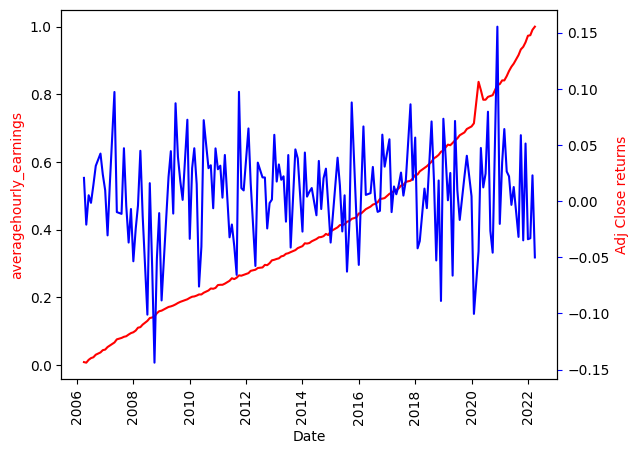

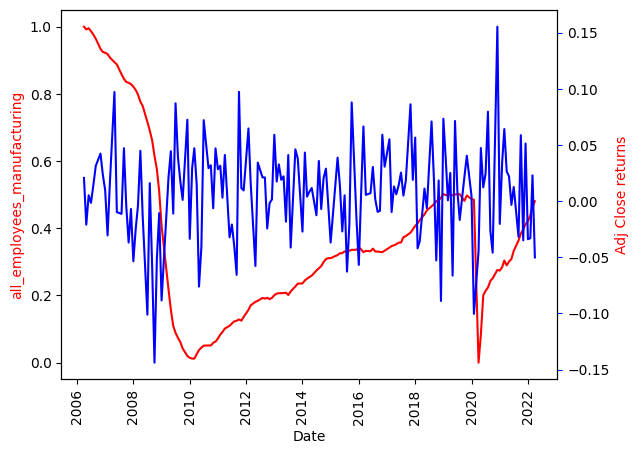

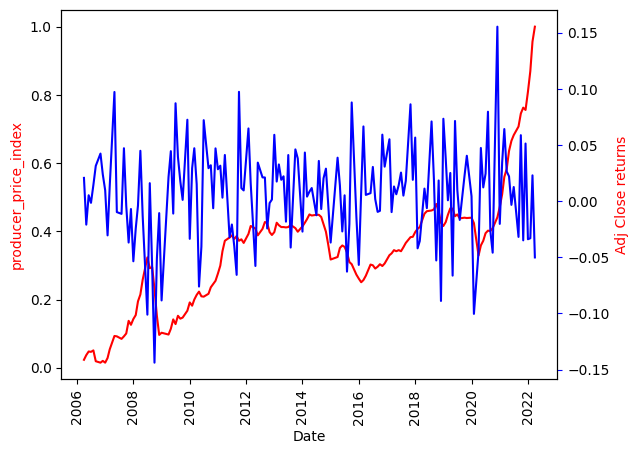

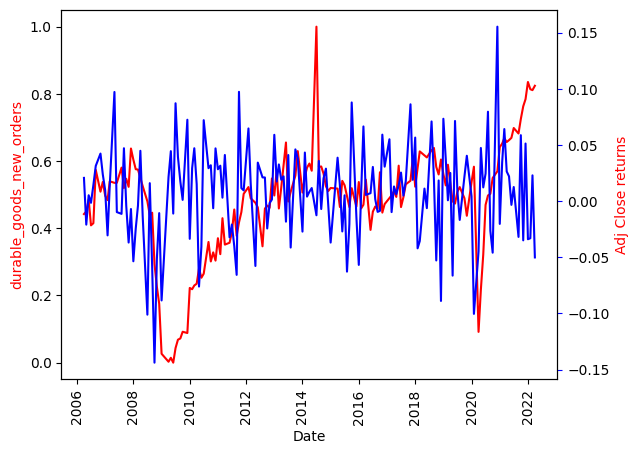

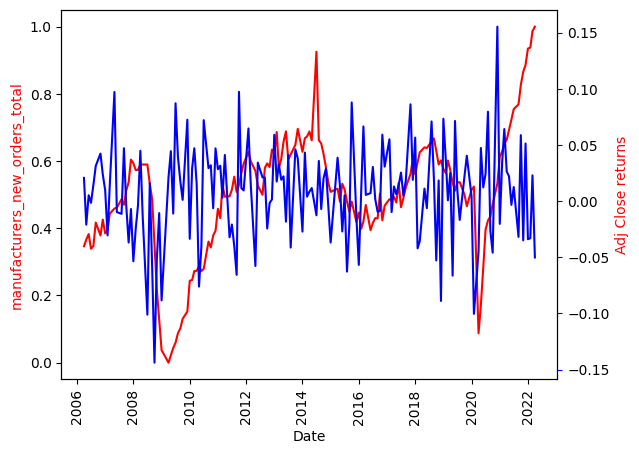

In [94]:
target = "Adj Close"
n_pts = 36

for j in np.arange(len(series)):
    # check the lag

    var = series[j]
    # Define Data
    # Choose sample of points to avoid clutter in plot
    df2plot = df2predict.iloc[len(df2predict) - n_pts : len(df2predict), ] # noQA E203
    x = df2predict.index
    data_1 = df2predict[var]
    data_2 = df2predict[target]

    # Create plot

    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Date")
    ax1.set_ylabel(var, color = "red")
    ax1.plot(x, data_1, color = "red")
    plt.xticks(rotation=90) # Rotates X-Axis Ticks by 45-degress
    
    # Adding twin axis
    ax2 = ax1.twinx()
    ax2.plot(x, data_2, color = "blue")

    # Add label
    ax2.set_ylabel("Adj Close returns", color = "red")
    ax2.tick_params(axis="y", color="blue")

    plt.show()

**4. Keras and TensorFlow**

- Seperating the data into predictors (X) and target (y):

In [101]:
X = df2predict[series].values
y = df2predict["Adj Close"].values

- Train/test split (80/20) in a time-ordered manner with  recent data being the unseen dataset.

In [102]:
test_size = 0.2
train_size = int((1-test_size) * len(X))
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]
len(X_train), len(X_test)

(132, 33)

- Building the Model

In [105]:
tf.random.set_seed(43)
model = tf.keras.Sequential([tf.keras.layers.Dense(1)])

# Compile the model specifying loss, and optimizer
model.compile(
    loss = tf.keras.losses.mae,
    optimizer = tf.keras.optimizers.SGD(
        learning_rate = 0.01, momentum = 0.9
    ),
    metrics = ["mae"],
)

model.fit(X_train, y_train, epochs=10, batch_size=8)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1547 - mae: 0.1547   
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1252 - mae: 0.1252 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0932 - mae: 0.0932 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0735 - mae: 0.0735 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0508 - mae: 0.0508 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0450 - mae: 0.0450 
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0445 - mae: 0.0445 
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0428 - mae: 0.0428 
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0485 - mae: 0.0485 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0376 - mae: 0.0376 


- Evaluating model performance:

In [109]:
preds = model.predict(X_test)
mae = tf.metrics.mae(y_true=y_test, y_pred=preds.squeeze()).numpy()
mse = tf.metrics.mse(y_true=y_test, y_pred=preds.squeeze()).numpy()
mae, mse

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


(0.049215578, 0.003880572)

- Lets see if we can improve the performance with more layers and different choices of the hyperparameters. 

In [112]:
tf.random.set_seed(42)
model_1 = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            8, activation = "sigmoid", input_shape=(X_train.shape[1],)
        ),
        tf.keras.layers.Dense(4, activation="sigmoid"),
        tf.keras.layers.Dense(1),
    ]
)

model_1.compile(
    loss = tf.keras.losses.mae, optimizer=tf.keras.optimizers.Adam(), metrics=["mae"]
)

model_1.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [113]:
# Performance
preds = model_1.predict(X_test)
mae = tf.metrics.mae(y_true=y_test, y_pred=preds.squeeze()).numpy()
mse = tf.metrics.mse(y_true=y_test, y_pred=preds.squeeze()).numpy()
mae, mse

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


(0.04097142, 0.0027820475)

- Increasing layers improved the performance of the model.